Rename all _nltk with _spacy to get the results for Spacy based preprocessed words

In [6]:
import pandas as pd
import numpy as np
import spacy

In [23]:
df = pd.read_csv('data/features_nltk.csv')
df = df[['headline', 'headline_cleaned', 'tokenized_text_nltk', 'lemmatized_text_nltk', 'is_sarcastic']]
df.head()

,headline,headline_cleaned,tokenized_text_nltk,lemmatized_text_nltk,is_sarcastic
0,former versace store clerk sues over secret 'b...,former versace store clerk sues over secret bl...,"['former', 'versace', 'store', 'clerk', 'sues'...","['former', 'versace', 'store', 'clerk', 'sue',...",0
1,the 'roseanne' revival catches up to our thorn...,the roseanne revival catches up to our thorny ...,"['the', 'roseanne', 'revival', 'catches', 'up'...","['roseanne', 'revival', 'catch', 'thorny', 'po...",0
2,mom starting to fear son's web series closest ...,mom starting to fear sons web series closest t...,"['mom', 'starting', 'to', 'fear', 'sons', 'web...","['mom', 'starting', 'fear', 'son', 'web', 'ser...",1
3,"boehner just wants wife to listen, not come up...",boehner just wants wife to listen not come up ...,"['boehner', 'just', 'wants', 'wife', 'to', 'li...","['boehner', 'just', 'want', 'wife', 'listen', ...",1
4,j.k. rowling wishes snape happy birthday in th...,jk rowling wishes snape happy birthday in the ...,"['jk', 'rowling', 'wishes', 'snape', 'happy', ...","['jk', 'rowling', 'wish', 'snape', 'happy', 'b...",0


## Word2Vec

In [24]:
from gensim.models import Word2Vec

In [25]:
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.split())
df['lemmatized_text_nltk'] = df['lemmatized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))
df['lemmatized_text_nltk'] = df['lemmatized_text_nltk'].apply(lambda x: x.split())

In [26]:
tokenized_sentences = df['tokenized_text_nltk'].tolist()
lemmatized_sentences = df['lemmatized_text_nltk'].tolist()

print(tokenized_sentences[0])


# Train Word2Vec models
w2v_tokenized = Word2Vec(tokenized_sentences, min_count=1, vector_size=100)
w2v_lemmatized = Word2Vec(lemmatized_sentences, min_count=1, vector_size=100)

['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', 'black', 'code', 'for', 'minority', 'shoppers']


In [27]:
print(type(tokenized_sentences[0]))

<class 'list'>


In [28]:
# Function to get word embeddings for a sentence
def get_word2vec_embeddings(model, sentence):
    embeddings = []
    for word in sentence.split():
        try:
            embeddings.append(model.wv[word])
        except KeyError:
            embeddings.append([0]*100)  # Default vector if word not found
    return embeddings


In [29]:
# Get word embeddings for tokenized and lemmatized sentences (for each word in the sentence)
df['tokenized_word2vec'] = df['tokenized_text_nltk'].apply(lambda x: [get_word2vec_embeddings(w2v_tokenized, y) for y in x])
df['lemmatized_word2vec'] = df['lemmatized_text_nltk'].apply(lambda x: [get_word2vec_embeddings(w2v_lemmatized, y) for y in x])

In [30]:
df.head()

,headline,headline_cleaned,tokenized_text_nltk,lemmatized_text_nltk,is_sarcastic,tokenized_word2vec,lemmatized_word2vec
0,former versace store clerk sues over secret 'b...,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se...","[former, versace, store, clerk, sue, secret, b...",0,"[[[-0.43288687, 0.52295107, 0.1836888, 0.11734...","[[[-0.3321601, 0.4542345, 0.18504947, 0.051315..."
1,the 'roseanne' revival catches up to our thorn...,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,...","[roseanne, revival, catch, thorny, political, ...",0,"[[[-0.3409838, 0.7695503, 0.37031835, 0.227100...","[[[-0.023489676, 0.013688089, 0.004950465, 0.0..."
2,mom starting to fear son's web series closest ...,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[mom, starting, fear, son, web, series, closes...",1,"[[[-0.42515793, 0.49868223, 0.1670215, 0.15606...","[[[-0.4878088, 0.6575842, 0.2602571, 0.1403433..."
3,"boehner just wants wife to listen, not come up...",boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[boehner, just, want, wife, listen, not, come,...",1,"[[[-0.10502883, 0.12605055, 0.050352406, 0.023...","[[[-0.083695516, 0.10050873, 0.039236642, 0.01..."
4,j.k. rowling wishes snape happy birthday in th...,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ...","[jk, rowling, wish, snape, happy, birthday, mo...",0,"[[[-0.032778095, 0.034946498, 0.020830588, 0.0...","[[[-0.023956316, 0.033857234, 0.0130906915, 0...."


In [90]:
def get_sentence_embedding(df):
    tok_w2v = df['tokenized_word2vec']
    sent_w2v = tok_w2v.apply(lambda x: np.asarray(x).squeeze().mean(axis=0))
    return sent_w2v

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
sent_w2v = get_sentence_embedding(df)

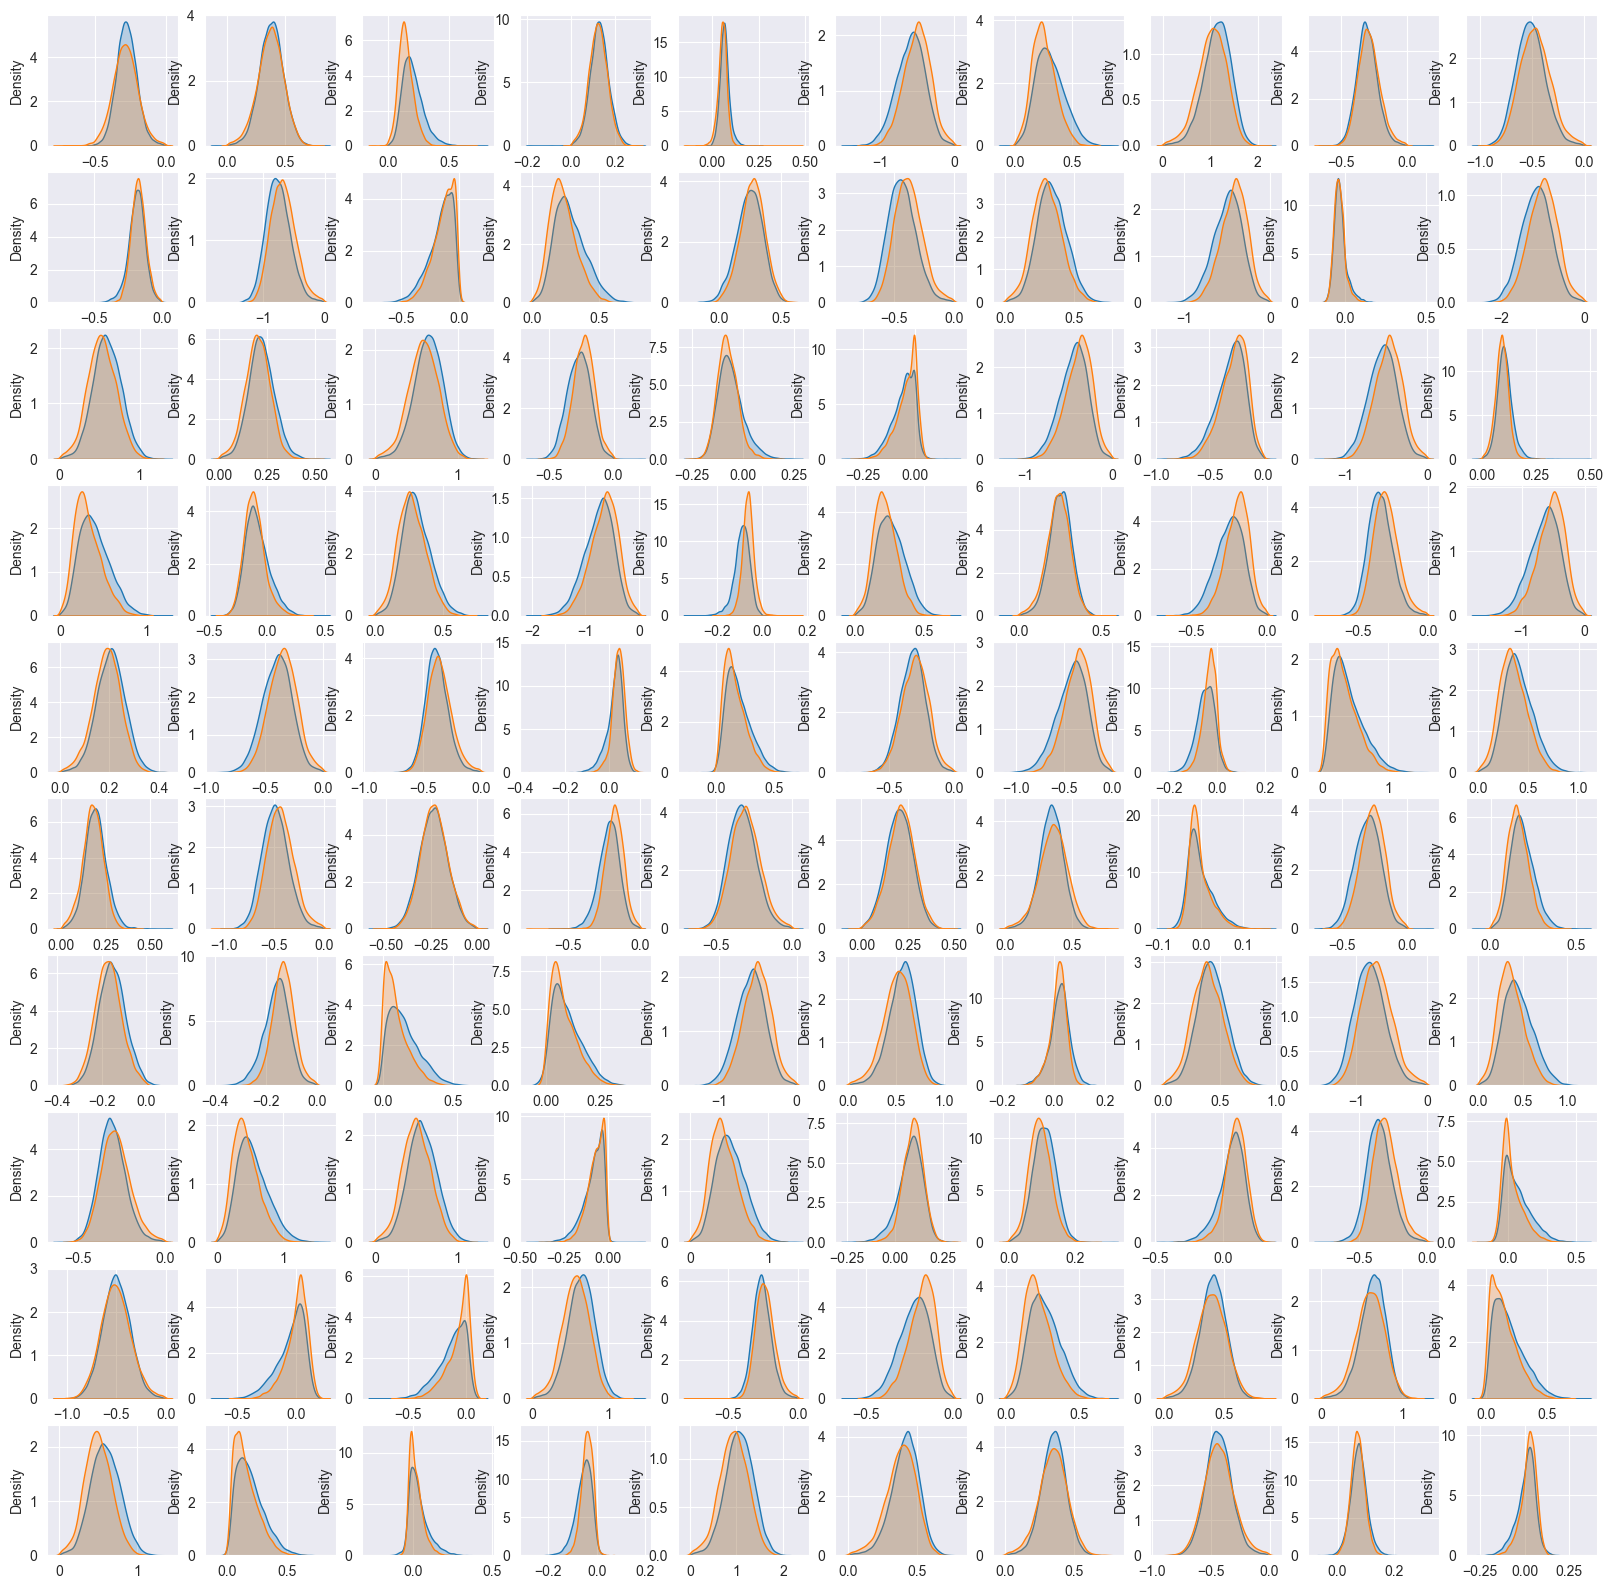

In [97]:
fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize = (20, 20))
for dim in range(100):
    idx = df[df['is_sarcastic'] == 0].index.values
    li = list(map(lambda x: sent_w2v[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim // 10, dim % 10])

    idx = df[df['is_sarcastic'] == 1].index.values
    li = list(map(lambda x: sent_w2v[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim // 10, dim % 10])

In [102]:
embeddings_df = pd.DataFrame(sent_w2v.tolist())

In [103]:
embeddings_df['is_sarcastic'] = df['is_sarcastic']

In [104]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,is_sarcastic
0,-0.277916,0.369655,0.131209,0.093909,0.065282,-0.415986,0.171417,0.931849,-0.281913,-0.407349,...,0.067590,-0.020600,-0.039524,0.807589,0.361372,0.347776,-0.416052,0.072453,0.048648,0
1,-0.284471,0.421426,0.190001,0.140623,0.069695,-0.606632,0.320125,1.176647,-0.345863,-0.533770,...,0.194592,0.056133,-0.068961,1.092008,0.431659,0.343344,-0.470444,0.075226,0.005265,0
2,-0.254498,0.306894,0.228951,0.135751,0.079637,-0.690274,0.383351,1.137361,-0.263948,-0.583966,...,0.270770,0.108402,-0.014508,1.138985,0.439420,0.312087,-0.359579,0.033770,-0.052569,1
3,-0.333966,0.377988,0.199021,0.179269,0.040914,-0.688688,0.337577,1.233976,-0.316631,-0.604651,...,0.272233,0.070753,-0.019635,1.210775,0.450098,0.346270,-0.463699,0.095307,-0.032172,1
4,-0.263545,0.393203,0.141420,0.112121,0.055599,-0.499468,0.275698,1.027777,-0.297604,-0.446830,...,0.157454,0.020230,-0.081670,0.924287,0.358096,0.322557,-0.432661,0.075511,0.019639,0


In [107]:
CORR_THRESHOLD = 0.2
features_w2v = np.arange(100)
correlations =[{'is_sarcastic': embeddings_df[f].corr(embeddings_df['is_sarcastic'])} for f in features_w2v]
train_corr_w2v = pd.DataFrame(correlations, index=features_w2v)

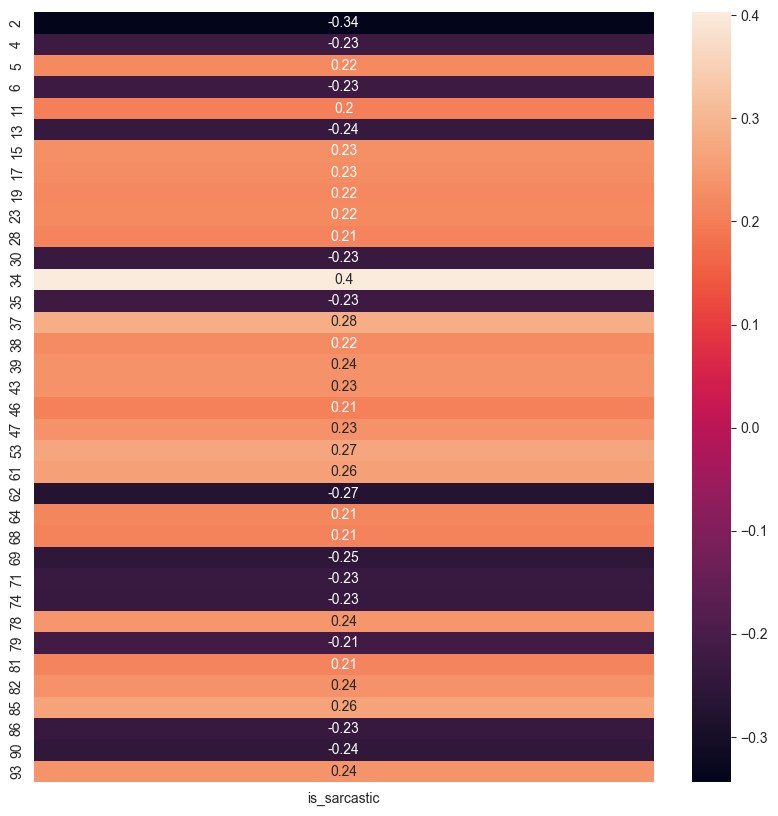

In [110]:
#Top features from word2vec - 36 features
mask = train_corr_w2v.apply(lambda x: abs(x) > CORR_THRESHOLD).to_numpy()
top_features = train_corr_w2v.loc[mask]

plt.figure(figsize = (10, 10))
sns.heatmap(top_features, annot=True)
plt.show()

## LDA2Vec

In [10]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2dense
import numpy as np

In [11]:
# Create a dictionary
tokenized_dict = Dictionary(tokenized_sentences)
lemmatized_dict = Dictionary(lemmatized_sentences)

In [12]:
# Convert to bag-of-words format
tokenized_corpus = [tokenized_dict.doc2bow(text) for text in tokenized_sentences]
lemmatized_corpus = [lemmatized_dict.doc2bow(text) for text in lemmatized_sentences]

In [13]:
# Train LDA models
lda_tokenized = LdaModel(tokenized_corpus, num_topics=10, id2word=tokenized_dict)
lda_lemmatized = LdaModel(lemmatized_corpus, num_topics=10, id2word=lemmatized_dict)

In [14]:
# Get topic distributions for each document
tokenized_topics = lda_tokenized.get_document_topics(tokenized_corpus)
lemmatized_topics = lda_lemmatized.get_document_topics(lemmatized_corpus)

In [15]:
tokenized_topics[0]

[(0, 0.14148138),
 (1, 0.09167796),
 (4, 0.5092524),
 (6, 0.08440458),
 (8, 0.12791975)]

In [16]:
# Convert topic distributions to dense vectors
def get_dense_topics(topics):
    dense_topics = []
    for topic in topics:
        topic_vector = [0]*10  # Assuming 10 topics
        for topic_id, prob in topic:
            topic_vector[topic_id] = prob
        dense_topics.append(topic_vector)
    return dense_topics

In [17]:
tokenized_dense_topics = get_dense_topics(tokenized_topics)
lemmatized_dense_topics = get_dense_topics(lemmatized_topics)

print(tokenized_dense_topics[0])

# Add dense topic vectors to DataFrame
df['Tokenized_lda_topics'] = tokenized_dense_topics
df['Lemmatized_lda_topics'] = lemmatized_dense_topics


[0.14152764, 0.09167853, 0, 0, 0.5092569, 0, 0.08435021, 0, 0.12792276, 0]


In [89]:
df.to_csv('data/embeddings_nltk.csv', index=False)

Please avoid pushing this csv file to github. The files are large and will take 5-6 minutes to store as a csv locally

## CountVectorizer and TfidfVectorizer

Owen

In [28]:
# Cell 1: Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
# Cell 2: Convert lists of tokens back to strings for vectorizers
tokenized_texts = [' '.join(tokens) for tokens in tokenized_sentences]
lemmatized_texts = [' '.join(tokens) for tokens in lemmatized_sentences]

In [22]:
# Cell 3: Implement CountVectorizer
# Create and fit CountVectorizer (max_features=1000 to avoid overly sparse matrices)
count_vec_tokenized = CountVectorizer(max_features=1000)
count_vec_lemmatized = CountVectorizer(max_features=1000)


# Transform text data into count vectors
count_tokenized = count_vec_tokenized.fit_transform(tokenized_texts)
count_lemmatized = count_vec_lemmatized.fit_transform(lemmatized_texts)

# Get feature names
tokenized_count_features = count_vec_tokenized.get_feature_names_out()
lemmatized_count_features = count_vec_lemmatized.get_feature_names_out()

print(f"CountVectorizer features shape (tokenized): {count_tokenized.shape}")
print(f"CountVectorizer features shape (lemmatized): {count_lemmatized.shape}")


CountVectorizer features shape (tokenized): (26709, 1000)
CountVectorizer features shape (lemmatized): (26709, 1000)


In [23]:

# Cell 4: Implement TfidfVectorizer
# Create and fit TfidfVectorizer (max_features=1000 to avoid overly sparse matrices)
tfidf_vec_tokenized = TfidfVectorizer(max_features=1000)
tfidf_vec_lemmatized = TfidfVectorizer(max_features=1000)

# Transform text data into TF-IDF vectors
tfidf_tokenized = tfidf_vec_tokenized.fit_transform(tokenized_texts)
tfidf_lemmatized = tfidf_vec_lemmatized.fit_transform(lemmatized_texts)

# Get feature names
tokenized_tfidf_features = tfidf_vec_tokenized.get_feature_names_out()
lemmatized_tfidf_features = tfidf_vec_lemmatized.get_feature_names_out()

print(f"TfidfVectorizer features shape (tokenized): {tfidf_tokenized.shape}")
print(f"TfidfVectorizer features shape (lemmatized): {tfidf_lemmatized.shape}")


TfidfVectorizer features shape (tokenized): (26709, 1000)
TfidfVectorizer features shape (lemmatized): (26709, 1000)


In [24]:

# Cell 5: Create function to extract top features
# Function to extract top features from each document
def get_top_features(matrix, feature_names, top_n=10):
    top_features_per_doc = []
    
    for i in range(matrix.shape[0]):
        # Get feature values for document i
        doc_features = matrix[i].toarray().flatten()
        # Get indices of top features (by value)
        top_indices = doc_features.argsort()[-top_n:][::-1]
        # Get feature names and their values
        top_features = [(feature_names[idx], doc_features[idx]) for idx in top_indices]
        top_features_per_doc.append(top_features)
    
    return top_features_per_doc

In [25]:

# Cell 6: Get top features and add to dataframe
# Get top 5 features for each document
tokenized_count_top = get_top_features(count_tokenized, tokenized_count_features, 5)
lemmatized_count_top = get_top_features(count_lemmatized, lemmatized_count_features, 5)
tokenized_tfidf_top = get_top_features(tfidf_tokenized, tokenized_tfidf_features, 5)
lemmatized_tfidf_top = get_top_features(tfidf_lemmatized, lemmatized_tfidf_features, 5)

# Add to dataframe
df['tokenized_count_top'] = tokenized_count_top
df['lemmatized_count_top'] = lemmatized_count_top
df['tokenized_tfidf_top'] = tokenized_tfidf_top
df['lemmatized_tfidf_top'] = lemmatized_tfidf_top

In [26]:
# Cell 7: Add dense feature vectors to dataframe
# Convert sparse matrices to dense arrays for selected features
# We'll take the first 100 features to avoid making the dataframe too large
tokenized_count_dense = count_tokenized[:, :100].toarray()
lemmatized_count_dense = count_lemmatized[:, :100].toarray()
tokenized_tfidf_dense = tfidf_tokenized[:, :100].toarray()
lemmatized_tfidf_dense = tfidf_lemmatized[:, :100].toarray()

# Add count vector features to dataframe
df['tokenized_count_features'] = tokenized_count_dense.tolist()
df['lemmatized_count_features'] = lemmatized_count_dense.tolist()
df['tokenized_tfidf_features'] = tokenized_tfidf_dense.tolist()
df['lemmatized_tfidf_features'] = lemmatized_tfidf_dense.tolist()


In [27]:
# Cell 8: Display examples of top TFIDF features
# Display example of top TFIDF features for the first few headlines
for i in range(5):
    print(f"Headline: {df['headline'].iloc[i]}")
    print(f"Top TFIDF features (tokenized): {df['tokenized_tfidf_top'].iloc[i]}")
    print("\n")


Headline: former versace store clerk sues over secret 'black code' for minority shoppers
Top TFIDF features (tokenized): [('store', 0.5083117545808206), ('secret', 0.4641108821678654), ('former', 0.4520097563458886), ('black', 0.3928886613364516), ('over', 0.34817736616156264)]


Headline: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Top TFIDF features (tokenized): [('worse', 0.4915417386795098), ('political', 0.43993415731592855), ('better', 0.41459558156287946), ('our', 0.3925549641699866), ('up', 0.29638310190796713)]


Headline: mom starting to fear son's web series closest thing she will have to grandchild
Top TFIDF features (tokenized): [('starting', 0.4073715548705109), ('fear', 0.4061818705229094), ('series', 0.3899743530784772), ('thing', 0.344629484832939), ('mom', 0.32718931745424296)]


Headline: boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Top TFIDF features (tokenized): [('ideas', 0.4591788451

In [29]:
# Cell 9: Save the updated dataframe
# Replace your existing save cell with this
df.to_csv('data/embeddings_count_tfidf.csv', index=False) 